# **Importing Libraries**

In [1]:
SEED = 42
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline


# Importing Preprocessing Library
from sklearn.preprocessing import OrdinalEncoder


# Importing Model Selection Library
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#Model
from sklearn.neighbors import KNeighborsRegressor

# Accuracy Metrics
from sklearn.metrics import r2_score

plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11


import missingno as miss

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import StandardScaler

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [3]:
#Importing datasets
train_df = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

dataset_union = [train_df,  test_df]

test_df_copy = test_df

print('The size of training dataset is {}'.format(train_df.shape))
print('The size of test dataset is {}'.format(test_df.shape))

The size of training dataset is (1460, 81)
The size of test dataset is (1459, 80)


 Test dataset has additional SalePrice column which we have to predict for the test dataset

/opt/conda/lib/python3.7/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  "Plotting a sparkline on an existing axis is not currently supported. "


Text(0.5, 1.0, 'Matrix plot for missing values in TEST dataset')

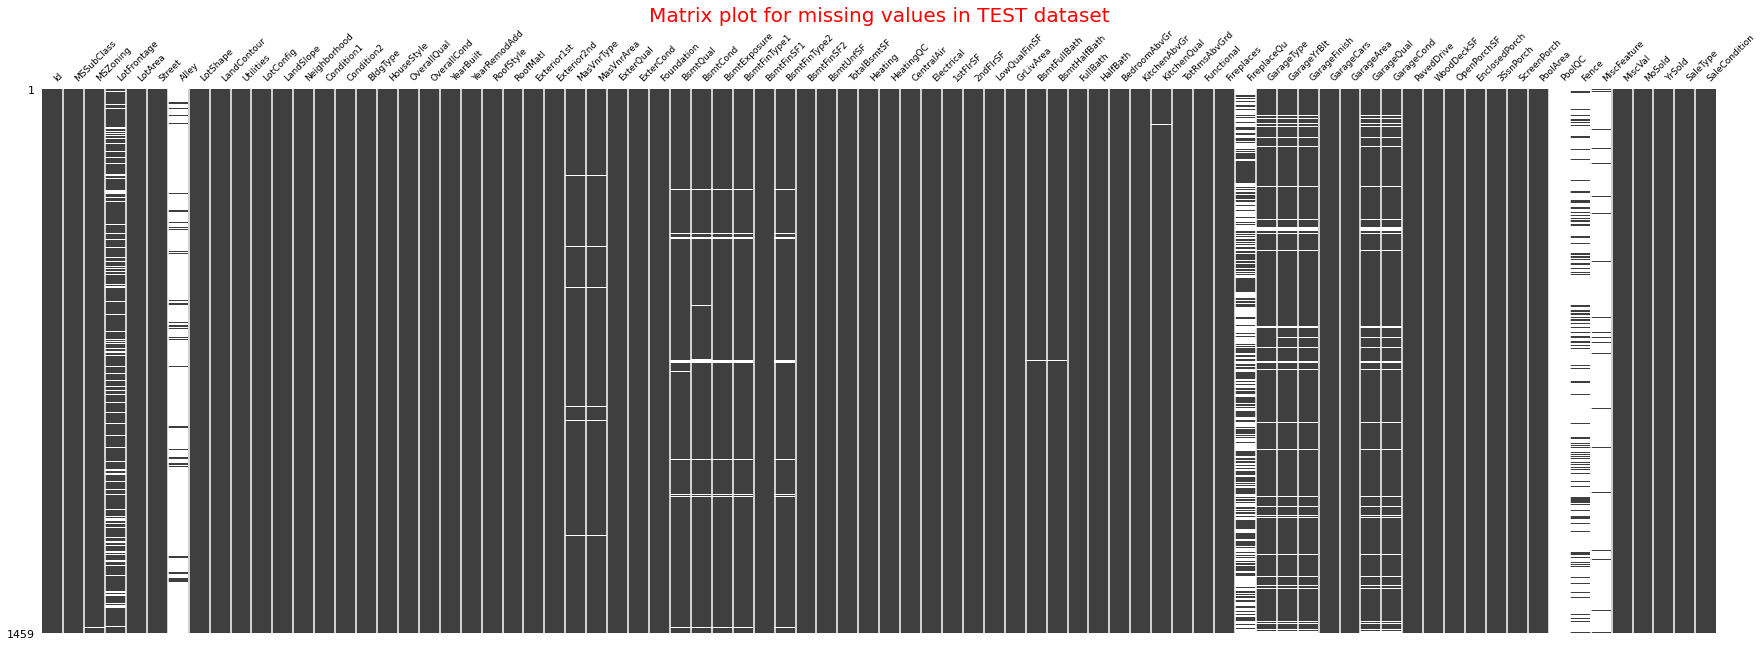

In [4]:
# Visualizing the Matrix Plot

fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(1,1,1)
miss.matrix(train_df, labels=True, fontsize=9, ax=ax1, sparkline=False)
ax1.set_title('Matrix plot for missing values in TRAIN dataset', size=20, color='red')

fig = plt.figure(figsize=(30,10))
ax2 = fig.add_subplot(1,1,1)
miss.matrix(test_df, labels=True, fontsize=9, ax=ax2)
ax2.set_title('Matrix plot for missing values in TEST dataset', size=20, color='red')



# **Numerical Features Analysis**

In [5]:
# Dropping ID column from the train dataset
train_df = train_df.drop('Id', axis=1)
test_df = test_df.drop('Id', axis=1)

numerical_var = [var for var in train_df.columns if train_df[var].dtype != 'O']
print('Total number of the Numerical features in the train dataset is {}'.format(len(numerical_var)))

Total number of the Numerical features in the train dataset is 37


/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


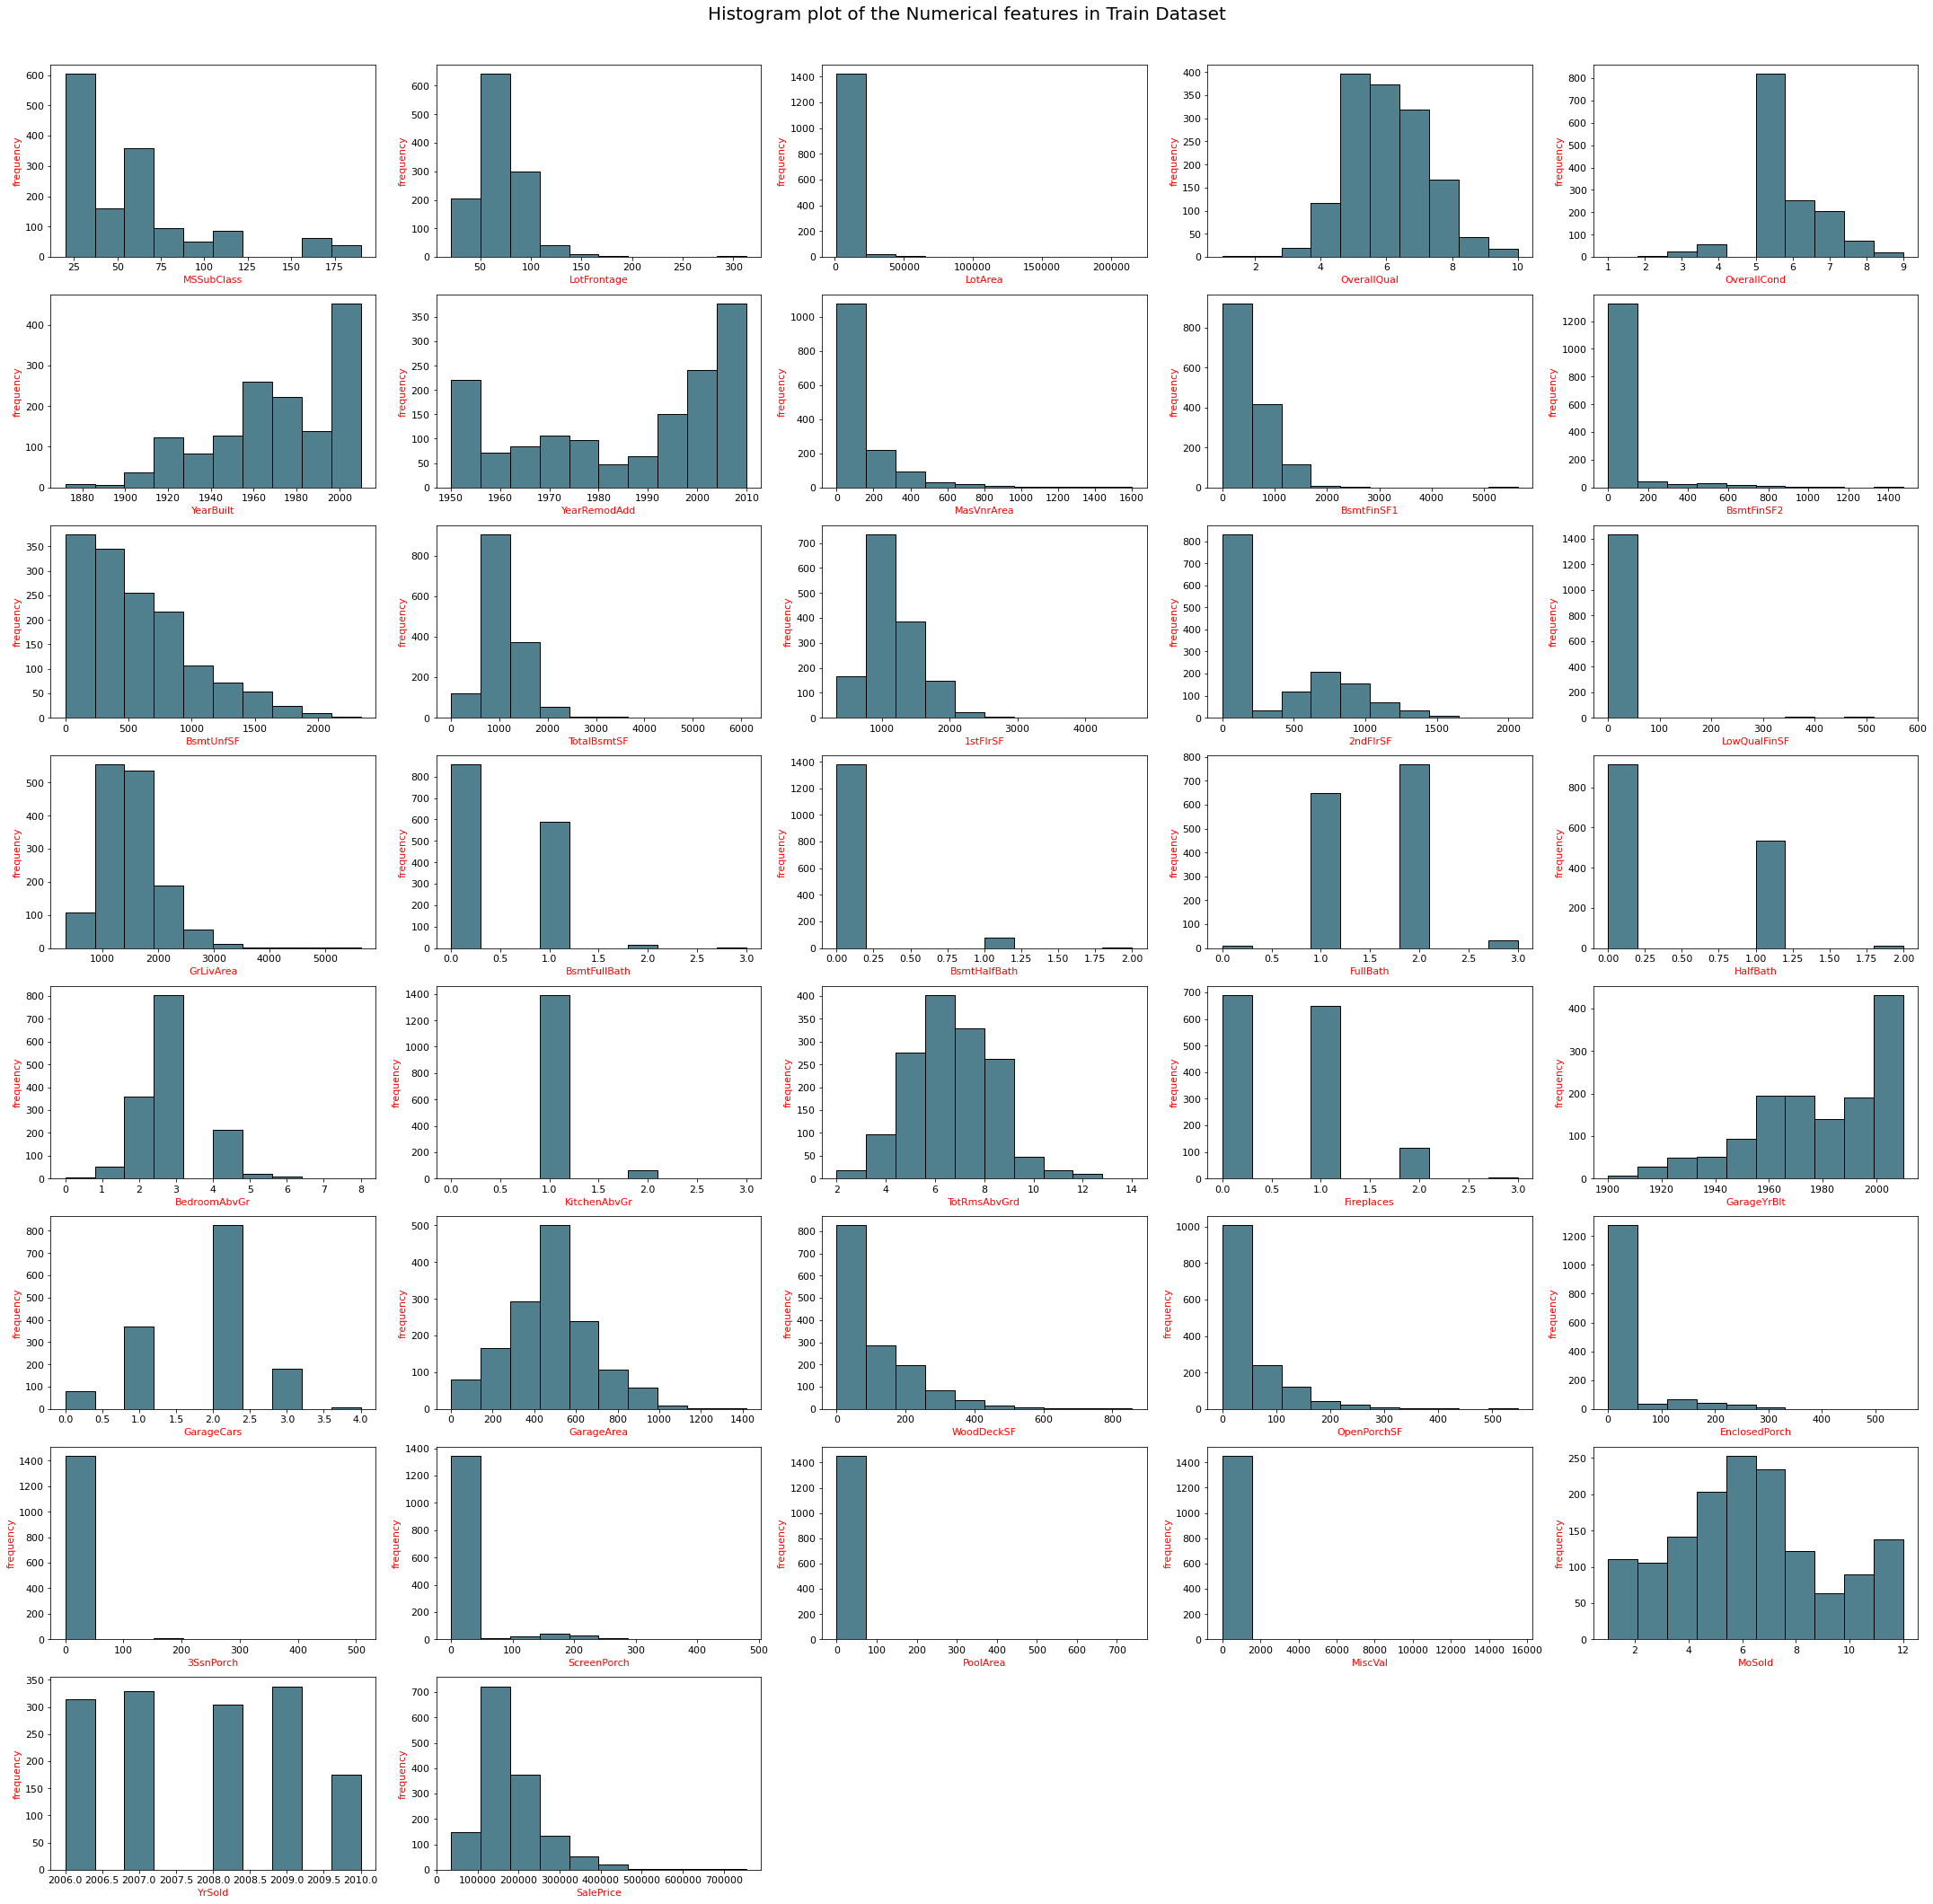

In [6]:
# Histogram plot of the Numerical features
plt.figure(figsize=(30,30))
for key, value in enumerate(numerical_var):
    plt.subplot(8,5, key+1)
    x = train_df.loc[:, value]
    plt.hist(x, color='#50808E',  edgecolor='black')
    plt.xlabel(value,size=11, color='red')
    plt.ylabel('frequency', size=11, color='red')
    plt.suptitle('Histogram plot of the Numerical features in Train Dataset', size=20, color='black')
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
plt.show()

In [7]:
# Exploring top Numerical features in the dataset

def top_numeric_corr (dataset, topN=5):
    numerical_df = dataset.select_dtypes(include=[np.number])
    numerical_df_corr = numerical_df.corr()['SalePrice'].sort_values(ascending=False)[1:topN]
    print('Top Numerical features positively corelated with the Sale Price: \n {}'.format(numerical_df_corr))


top_numeric_corr(train_df)    

Top Numerical features positively corelated with the Sale Price: 
 OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64


In [8]:
# Scatter plot of the Numerical Features

plt.figure(figsize=(30,30))
for key, value in enumerate(numerical_var):
  plt.subplot(8,5, key+1)
  x = train_df.loc[: , value]
  plt.scatter(x, y=train_df['SalePrice'], color='#50808E', alpha=0.3)
  plt.xlabel(value, size=11, color='red')
  plt.suptitle('Scatter Plots of Numerical Features', size=20, color='red')
  plt.tight_layout()
  plt.subplots_adjust(top=0.95)
plt.show()

Scatter plot reveals few important observation, the coorelation indeed very strong for OverallQual, GrLivingArea and GarageArea

## Imputing Missing values in the Numerical Dataset

In [9]:
def missing_val_calculate(dataset, Dtype):
    numerical_df =dataset.select_dtypes(include=[np.number])
    for cols in numerical_df:
        if dataset[cols].isnull().sum()>0:
            print('The {} column in {} dataset has {} missing values'.format(cols,Dtype, dataset[cols].isnull().sum()))
            
#Missing values for training dataset
missing_val_calculate(train_df, 'TRAIN')   

The LotFrontage column in TRAIN dataset has 259 missing values
The MasVnrArea column in TRAIN dataset has 8 missing values
The GarageYrBlt column in TRAIN dataset has 81 missing values


In [10]:
#Missing values in test dataset
missing_val_calculate(test_df, 'TEST') 

The LotFrontage column in TEST dataset has 227 missing values
The MasVnrArea column in TEST dataset has 15 missing values
The BsmtFinSF1 column in TEST dataset has 1 missing values
The BsmtFinSF2 column in TEST dataset has 1 missing values
The BsmtUnfSF column in TEST dataset has 1 missing values
The TotalBsmtSF column in TEST dataset has 1 missing values
The BsmtFullBath column in TEST dataset has 2 missing values
The BsmtHalfBath column in TEST dataset has 2 missing values
The GarageYrBlt column in TEST dataset has 78 missing values
The GarageCars column in TEST dataset has 1 missing values
The GarageArea column in TEST dataset has 1 missing values


In [11]:
def missing_value_imputer(dataset, Dtype):
    numerical_df =dataset.select_dtypes(include=[np.number])
    for cols in numerical_df.columns:  
         if dataset[cols].isnull().mean():
                most_frequent_Nval = dataset[cols].mode()[0]
                dataset[cols].fillna(most_frequent_Nval, inplace=True)
    for cols in numerical_df.columns:
        flag=0
        if dataset[cols].isnull().sum() !=0:
            flag = flag+1
    if flag==0:
        print('All missing values from the {} dataset have been imputed by mode value'.format(Dtype))
        
missing_value_imputer(train_df, 'TRAIN')

All missing values from the TRAIN dataset have been imputed by mode value


In [12]:
missing_value_imputer(test_df, 'TEST')

All missing values from the TEST dataset have been imputed by mode value


## Handeling Outliers in the Train Dataset

It is important to handel extreme values in the dataset for higher efficiency of the model. For good understanding please check: [link](https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)

In [13]:
def remove_outliers(dataset, factor=1.5):
    
    ''' A function to remove outliers of top five positively corelated with the SalePrice from the Dataset'''
    
    numerical_features = dataset.select_dtypes(include=[np.number])
    numerical_features_corr =numerical_features.corr()['SalePrice'].sort_values(ascending=False)[1:6]
    for feature in numerical_features_corr.index:
        Q1 = dataset[feature].quantile(0.25)
        Q3 = dataset[feature].quantile(0.75)
        IQR = (Q3-Q1)
        dataset = dataset[(dataset[feature]>= Q1-factor*IQR) & (dataset[feature]<=Q3+factor*IQR)]
    return dataset


train_df = remove_outliers(train_df)

print('New Shape of the Train dataset after outlier removal is {}'.format(train_df.shape))

New Shape of the Train dataset after outlier removal is (1350, 80)


## Regularization of Numerical Features

In [14]:
# Regularization of the Numerical features

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()

train_copy = train_df.copy()
num_train_df = train_df.select_dtypes(include=[np.number])
num_train_df = num_train_df.drop('SalePrice', axis=1)
for cols in num_train_df.columns:
    transformer_train = standard_scaler.fit(train_df[[cols]])
    train_df[cols] = transformer_train.transform(train_df[[cols]])


print('Train dataset shape after regularization of the Numerical Features {}'.format(train_df.shape))

Train dataset shape after regularization of the Numerical Features (1350, 80)


In [15]:
train_df.head(2)

MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0    0.064526       RL    -0.101119 -0.197344   Pave   NaN      Reg   
1   -0.874666       RL     0.622692 -0.059227   Pave   NaN      Reg   

  LandContour Utilities LotConfig  ...  PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ... -0.046952    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ... -0.046952    NaN   NaN         NaN   

    MiscVal    MoSold    YrSold  SaleType  SaleCondition  SalePrice  
0 -0.080556 -1.595922  0.144749        WD         Normal     208500  
1 -0.080556 -0.493315 -0.606830        WD         Normal     181500  

[2 rows x 80 columns]

In [16]:
# Regularization for TEST numerical dataset

num_test_df = train_copy.select_dtypes(include=[np.number])
num_test_df = num_test_df.drop('SalePrice', axis=1)
for cols in num_test_df.columns:
    transformer_test = standard_scaler.fit(train_copy[[cols]])
    test_df[cols] = transformer_test.transform(test_df[[cols]])

print('Test dataset shape after regularization {}'.format(test_df.shape))
    

Test dataset shape after regularization (1459, 79)


In [17]:
test_df.head(2)

MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0   -0.874666       RH     0.622692  0.183618   Pave   NaN      Reg   
1   -0.874666       RL     0.670947  0.501287   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... ScreenPorch  PoolArea PoolQC  Fence  \
0         Lvl    AllPub    Inside  ...    2.019655 -0.046952    NaN  MnPrv   
1         Lvl    AllPub    Corner  ...   -0.272096 -0.046952    NaN    NaN   

  MiscFeature    MiscVal    MoSold    YrSold  SaleType  SaleCondition  
0         NaN  -0.080556 -0.125779  1.647907        WD         Normal  
1        Gar2  24.823933 -0.125779  1.647907        WD         Normal  

[2 rows x 79 columns]

# **Categorical feature Analysis**

In [18]:
categorical_df = train_df.select_dtypes(exclude=[np.number])
for cols in categorical_df.columns:
    print('Uniques values in {} category are: {}, total {} counts'.format(cols, train_df[cols].unique(), len(train_df[cols].unique())))

Uniques values in MSZoning category are: ['RL' 'RM' 'C (all)' 'FV' 'RH'], total 5 counts
Uniques values in Street category are: ['Pave' 'Grvl'], total 2 counts
Uniques values in Alley category are: [nan 'Grvl' 'Pave'], total 3 counts
Uniques values in LotShape category are: ['Reg' 'IR1' 'IR2' 'IR3'], total 4 counts
Uniques values in LandContour category are: ['Lvl' 'Bnk' 'Low' 'HLS'], total 4 counts
Uniques values in Utilities category are: ['AllPub' 'NoSeWa'], total 2 counts
Uniques values in LotConfig category are: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3'], total 5 counts
Uniques values in LandSlope category are: ['Gtl' 'Mod' 'Sev'], total 3 counts
Uniques values in Neighborhood category are: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Timber' 'Gilbert' 'ClearCr' 'Edwards' 'NPkVill' 'StoneBr'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste'], total 25 counts
Uniques values in Condition1 cate

Imputing Missing values in the categorical features

In [19]:
def missing_val_calculate(dataset, Dtype):
    categorical_df =dataset.select_dtypes(exclude=[np.number])
    for cols in categorical_df:
        if dataset[cols].isnull().sum()>0:
            print('The {} column in {} dataset has {:.2f}% missing values, total values{}'.format(cols, Dtype, (dataset[cols].isnull().sum()/dataset.shape[0])*100, dataset.shape[0]))

missing_val_calculate(train_df, 'TRAIN')   #Missing values for training dataset

The Alley column in TRAIN dataset has 93.56% missing values, total values1350
The MasVnrType column in TRAIN dataset has 0.44% missing values, total values1350
The BsmtExposure column in TRAIN dataset has 0.07% missing values, total values1350
The Electrical column in TRAIN dataset has 0.07% missing values, total values1350
The FireplaceQu column in TRAIN dataset has 48.37% missing values, total values1350
The GarageType column in TRAIN dataset has 5.26% missing values, total values1350
The GarageFinish column in TRAIN dataset has 5.26% missing values, total values1350
The GarageQual column in TRAIN dataset has 5.26% missing values, total values1350
The GarageCond column in TRAIN dataset has 5.26% missing values, total values1350
The PoolQC column in TRAIN dataset has 99.78% missing values, total values1350
The Fence column in TRAIN dataset has 80.22% missing values, total values1350
The MiscFeature column in TRAIN dataset has 96.44% missing values, total values1350


In [20]:
missing_val_calculate(test_df, 'TEST')

The MSZoning column in TEST dataset has 0.27% missing values, total values1459
The Alley column in TEST dataset has 92.67% missing values, total values1459
The Utilities column in TEST dataset has 0.14% missing values, total values1459
The Exterior1st column in TEST dataset has 0.07% missing values, total values1459
The Exterior2nd column in TEST dataset has 0.07% missing values, total values1459
The MasVnrType column in TEST dataset has 1.10% missing values, total values1459
The BsmtQual column in TEST dataset has 3.02% missing values, total values1459
The BsmtCond column in TEST dataset has 3.08% missing values, total values1459
The BsmtExposure column in TEST dataset has 3.02% missing values, total values1459
The BsmtFinType1 column in TEST dataset has 2.88% missing values, total values1459
The BsmtFinType2 column in TEST dataset has 2.88% missing values, total values1459
The KitchenQual column in TEST dataset has 0.07% missing values, total values1459
The Functional column in TEST 

In [21]:
drop_cols = ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
train_df = train_df.drop(drop_cols, axis=1)
test_df = test_df.drop(drop_cols, axis=1)

print('New Shape of the Training dataset is {}'.format(train_df.shape))
print('New Shape of the Testing dataset is {}'.format(test_df.shape))

New Shape of the Training dataset is (1350, 76)
New Shape of the Testing dataset is (1459, 75)


In [22]:
def missing_value_imputer(dataset, Dtype):
    categorical_df =dataset.select_dtypes(exclude=[np.number])
    for cols in categorical_df.columns:  
         if dataset[cols].isnull().mean():
                most_frequent_Cval = dataset[cols].mode()[0]
                dataset[cols].fillna(most_frequent_Cval, inplace=True)
    for cols in categorical_df.columns:
        flag=0
        if dataset[cols].isnull().sum() !=0:
            flag = flag+1
    if flag==0:
        print('All missing values from the {} dataset have been imputed'.format(Dtype))
        
missing_value_imputer(train_df, 'TRAIN')

All missing values from the TRAIN dataset have been imputed


In [23]:
missing_value_imputer(test_df, 'TEST')

All missing values from the TEST dataset have been imputed


In [24]:
categorical_var= [var for var in  train_df.columns if train_df[var].dtype=='O']
plt.figure(figsize=(30,50))
for key, value in enumerate(categorical_var):
    plt.subplot(8,5, key+1)
    sns.boxplot(x=value, y='SalePrice', data=train_df)
    plt.xticks(rotation=90)
    plt.xlabel(value, color='red', size=10)
    plt.ylabel('Sales Price', color='red', size=10)
    plt.suptitle('Box Plot of all Categorical Features', size=20, color='Black')
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
plt.show()

## Encoder for Categorical Features

Most Machine Learning algorithm prefers to work with numbers , so lets convert these categorical from text to numbers. For this we can use Scikit-Learn's Ordinal Encoder Class.

In [25]:
from sklearn.preprocessing import LabelEncoder

#making an encoder object
label_encoder = LabelEncoder()

#fit and transform all categorical variables
cat_cols = [var for var in train_df.columns if train_df[var].dtype == 'O']
for cols in cat_cols:
    label_encoder.fit(pd.concat([train_df[cols], test_df[cols]], axis=0, sort=False))
    train_df[cols] = label_encoder.transform(train_df[[cols]])
    test_df [cols] = label_encoder.transform(test_df[[cols]])
    
print('Label Encoding completed......')

Label Encoding completed......


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [26]:
train_df.head()

MSSubClass  MSZoning  LotFrontage   LotArea  Street  LotShape  LandContour  \
0    0.064526         3    -0.101119 -0.197344       1         3            3   
1   -0.874666         3     0.622692 -0.059227       1         3            3   
2    0.064526         3     0.043643  0.138941       1         0            3   
3    0.299324         3    -0.342390 -0.065232       1         0            3   
4    0.064526         3     0.815709  0.500447       1         0            3   

   Utilities  LotConfig  LandSlope  ...  EnclosedPorch  3SsnPorch  \
0          0          4          0  ...       -0.36787  -0.118152   
1          0          2          0  ...       -0.36787  -0.118152   
2          0          4          0  ...       -0.36787  -0.118152   
3          0          0          0  ...        4.25300  -0.118152   
4          0          2          0  ...       -0.36787  -0.118152   

   ScreenPorch  PoolArea   MiscVal    MoSold    YrSold  SaleType  \
0    -0.272096 -0.046952 -0.080556 -1.595922  0.144749         8   
1    -0.272096 -0.046952 -0.080556 -0.493315 -0.606830         8   
2    -0.272096 -0.046952 -0.080556  0.976828  0.144749         8   
3    -0.272096 -0.046952 -0.080556 -1.595922 -1.358410         8   
4    -0.272096 -0.046952 -0.080556  2.079435  0.144749         8   

   SaleCondition  SalePrice  
0              4     208500  
1              4     181500  
2              4     223500  
3              0     140000  
4              4     250000  

[5 rows x 76 columns]

In [27]:
test_df.head()

MSSubClass  MSZoning  LotFrontage   LotArea  Street  LotShape  LandContour  \
0   -0.874666         2     0.622692  0.183618       1         3            3   
1   -0.874666         3     0.670947  0.501287       1         0            3   
2    0.064526         3     0.333168  0.448803       1         0            3   
3    0.064526         3     0.526184 -0.013829       1         0            3   
4    1.473314         3    -1.162709 -0.611094       1         0            1   

   Utilities  LotConfig  LandSlope  ...  OpenPorchSF  EnclosedPorch  \
0          0          4          0  ...    -0.722338       -0.36787   
1          0          0          0  ...    -0.146449       -0.36787   
2          0          4          0  ...    -0.178443       -0.36787   
3          0          4          0  ...    -0.146449       -0.36787   
4          0          4          0  ...     0.589410       -0.36787   

   3SsnPorch  ScreenPorch  PoolArea    MiscVal    MoSold    YrSold  SaleType  \
0  -0.118152     2.019655 -0.046952  -0.080556 -0.125779  1.647907         8   
1  -0.118152    -0.272096 -0.046952  24.823933 -0.125779  1.647907         8   
2  -0.118152    -0.272096 -0.046952  -0.080556 -1.228386  1.647907         8   
3  -0.118152    -0.272096 -0.046952  -0.080556 -0.125779  1.647907         8   
4  -0.118152     2.478005 -0.046952  -0.080556 -1.963457  1.647907         8   

   SaleCondition  
0              4  
1              4  
2              4  
3              4  
4              4  

[5 rows x 75 columns]

/opt/conda/lib/python3.7/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  "Plotting a sparkline on an existing axis is not currently supported. "


Text(0.5, 1.0, 'Matrix plot for missing values in TEST dataset after PREPROCESSING ')

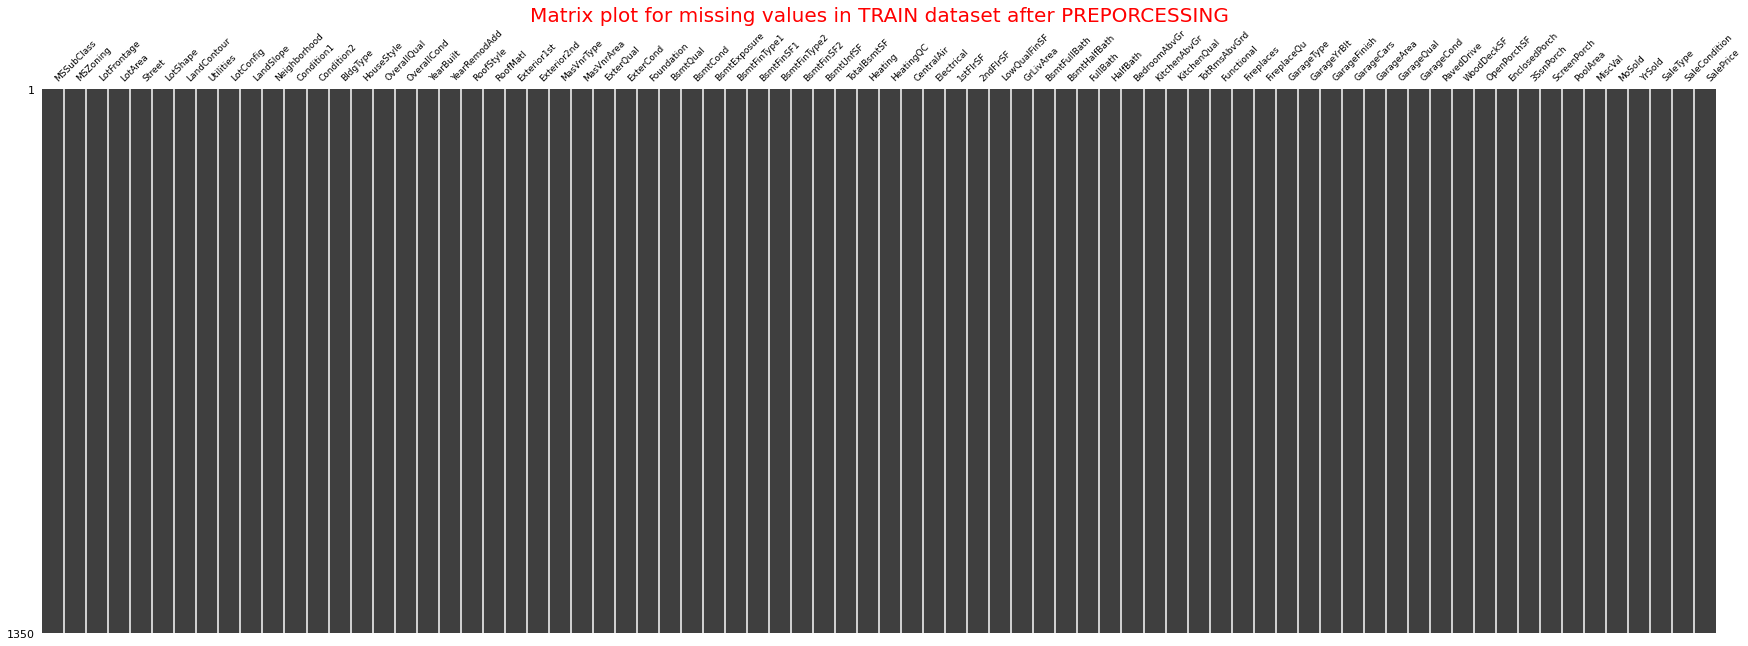

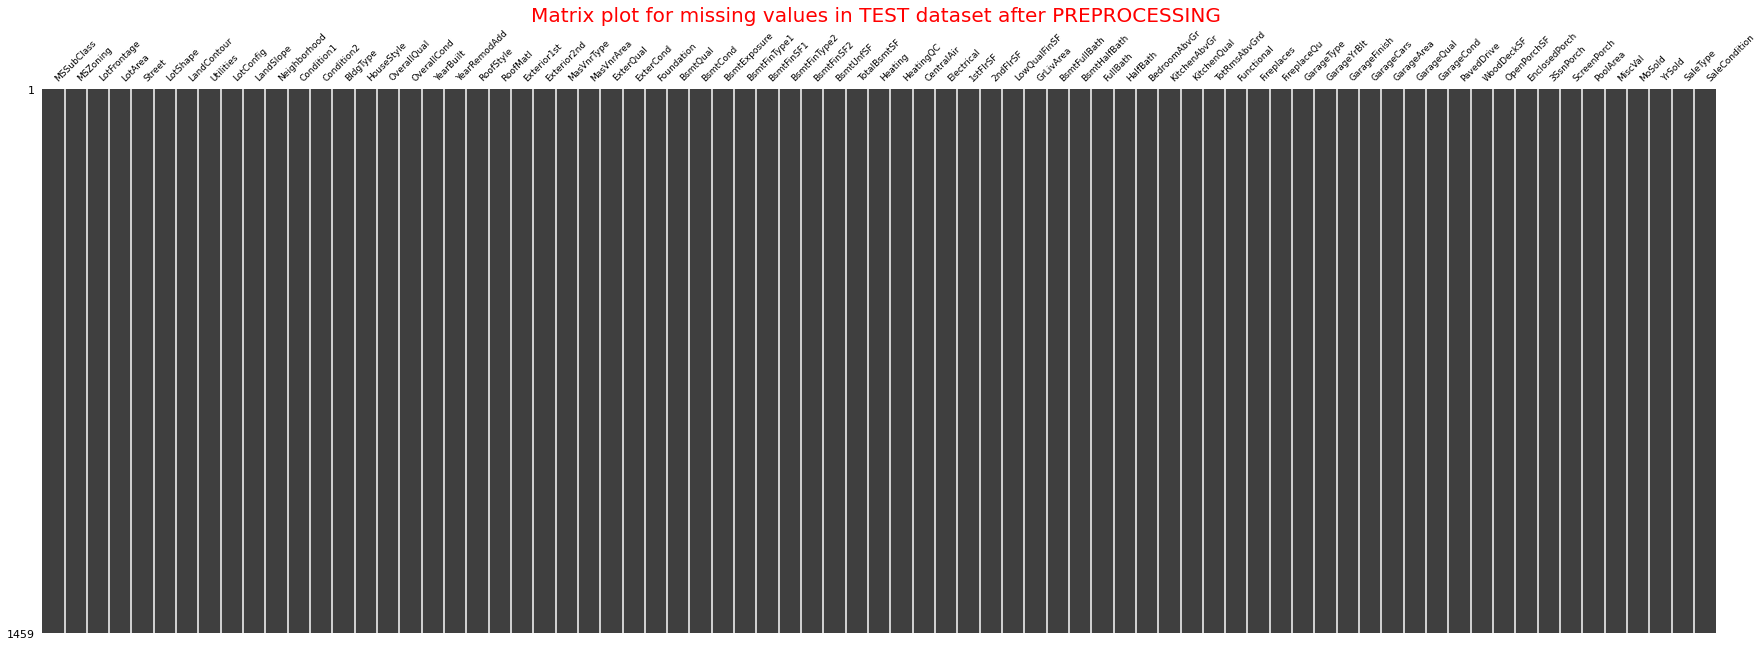

In [28]:
fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(1,1,1)
miss.matrix(train_df, labels=True, fontsize=9, ax=ax1)
ax1.set_title('Matrix plot for missing values in TRAIN dataset after PREPORCESSING', size=20, color='red')

fig = plt.figure(figsize=(30,10))
ax2 = fig.add_subplot(1,1,1)
miss.matrix(test_df, labels=True, fontsize=9, ax=ax2)
ax2.set_title('Matrix plot for missing values in TEST dataset after PREPROCESSING ', size=20, color='red')


## What we have achieved so far after all previous steps:
    1. Identified Missing values in both categorical and Numerical features
    2. Missing values imputed with mode in case of numerical and categorical category
    3. Oridanl encoding of categorical features 
    4. Outlier removed from the training set
    

# **Model Selection and Hypertuning**

## **Analysis of Target feature: SalePrice**

The Skewness of the Target Variable is: 1.105



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8802dc2c10>,
      dtype=object)

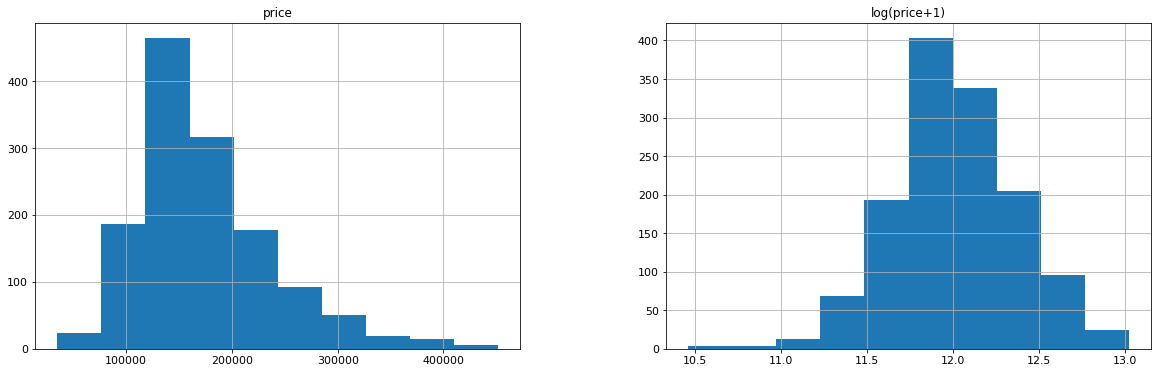

In [29]:
print('The Skewness of the Target Variable is: {:.3f}\n'.format(train_df['SalePrice'].skew()))


matplotlib.rcParams['figure.figsize'] = (20.0, 6.0)
prices = pd.DataFrame({'price': train_df['SalePrice'], 'log(price+1)':np.log1p(train_df['SalePrice'])})
prices.hist()

In [30]:
y = np.log1p(train_df['SalePrice'])
print('Skewness of the Target feature after log transformation: {:.3f}'.format(y.skew()))

Skewness of the Target feature after log transformation: -0.115


After log transformation SalePrice distribution is normal and skewness also reduced

In [31]:
y = np.log1p(train_df['SalePrice'])
X = train_df.drop('SalePrice', axis=1)

print('Size of independent features: {}'.format(X.shape))
print('Size of dependent feature is {}'.format(y.shape))

Size of independent features: (1350, 75)
Size of dependent feature is (1350,)


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

print('X_train shape: {}'.format(X_train.shape))

print('X_test shape: {}'.format(X_val.shape))

X_train shape: (1080, 75)
X_test shape: (270, 75)


## Simple Linear Regression Model Without Any Penalty

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Linear Regression object
lr = LinearRegression()
lr.fit(X_train, y_train)


lr_scores = cross_val_score(lr, X_val, y_val, scoring='neg_mean_squared_error', cv=10)


# scores on the validation dataset
lr_rmse_val_scores = np.sqrt(-lr_scores)

In [34]:
def display_scores (val):
    '''
    A fnction to display scores after cross validation 
    
    '''
    print('Scores: {}'.format(val))
    print('Mean score Value {}'.format(val.mean()))
    print('Standard Deviation {}'.format(val.std()))

display_scores(lr_rmse_val_scores)

Scores: [1.32213780e-01 1.36739572e-01 1.48978979e-01 2.23298984e-01
 1.24021394e-01 1.64379410e-01 2.44617429e-01 9.32560212e+09
 1.17910762e-01 1.34027310e-01]
Mean score Value 932560212.0236689
Standard Deviation 2797680635.59561


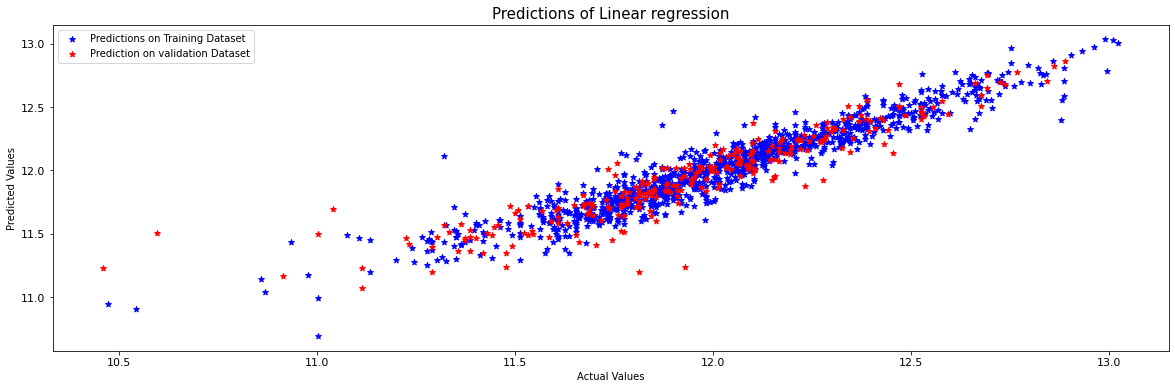

In [35]:
y_train_predict = lr.predict(X_train)
y_val_predict = lr.predict(X_val)


#  Plotting Residuals

plt.scatter(y_train_predict, y_train_predict-y_train, c='blue', marker ='*', label='Residual on Training Data')
plt.scatter(y_val_predict, y_val_predict-y_val, c='red', marker ='*', label='Residual on Validation Data')
plt.hlines(y = 0, xmin = 10.5, xmax = 13, color = "black")
plt.title('Linear Regression Residuals', size=15)
plt.xlabel('Predicted Value')
plt.ylabel('Rediual Values')
plt.legend(loc='best')
plt.show()


# Plotting Predictions

plt.scatter(y_train,y_train_predict, c='blue', marker='*', label='Predictions on Training Dataset' )
plt.scatter(y_val, y_val_predict, c='red', marker='*', label='Prediction on validation Dataset')
plt.title('Predictions of Linear regression', size=15)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend(loc='best')
plt.show()

## Linear Regression with L2 Penalty- Ridge Regression

For a linear model, regularization is typically achieved by constraining the weights of the model.

In [36]:
# finding best parameter alpha for ridge regularization
from sklearn.linear_model import RidgeCV

alphas = [0.003, 0.03, 0.3, 3.0, 30.0, 50.0, 60.0, 80.0]
ridge_clf = RidgeCV(alphas)
ridge_clf.fit(X_train, y_train)

print('Best alpha for Ridge: {}'.format(ridge_clf.alpha_))

ridge_scores = cross_val_score(ridge_clf, X_val, y_val, scoring='neg_mean_squared_error', cv=10 )
ridge_rmse_val_scores = np.sqrt(-ridge_scores)


display_scores(ridge_rmse_val_scores)

Best alpha for Ridge: 30.0
Scores: [0.13363531 0.08443892 0.10620113 0.24130333 0.10800688 0.15827332
 0.12584347 0.21674557 0.09101007 0.14491851]
Mean score Value 0.14103765081335187
Standard Deviation 0.04938974885456863


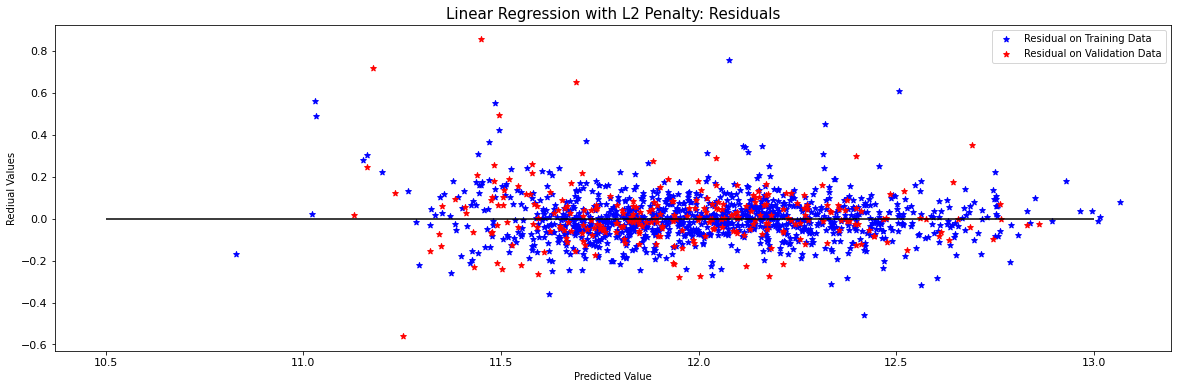

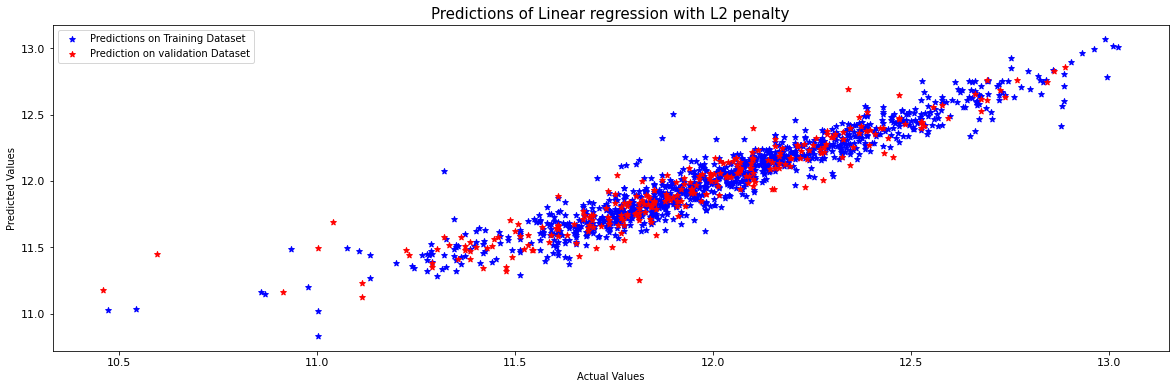

In [37]:
y_train_ridge_predict = ridge_clf.predict(X_train)
y_val_ridge_predict = ridge_clf.predict(X_val)



#  Plotting Residuals

plt.scatter(y_train_ridge_predict, y_train_ridge_predict-y_train, c='blue', marker ='*', label='Residual on Training Data')
plt.scatter(y_val_ridge_predict, y_val_ridge_predict-y_val, c='red', marker ='*', label='Residual on Validation Data')
plt.hlines(y = 0, xmin = 10.5, xmax = 13, color = "black")
plt.title('Linear Regression with L2 Penalty: Residuals', size=15)
plt.xlabel('Predicted Value')
plt.ylabel('Rediual Values')
plt.legend(loc='best')
plt.show()


# Plotting Predictions

plt.scatter(y_train,y_train_ridge_predict, c='blue', marker='*', label='Predictions on Training Dataset' )
plt.scatter(y_val, y_val_ridge_predict, c='red', marker='*', label='Prediction on validation Dataset')
plt.title('Predictions of Linear regression with L2 penalty', size=15)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend(loc='best')
plt.show()


Ridge picked 75 features and dropped 0 features


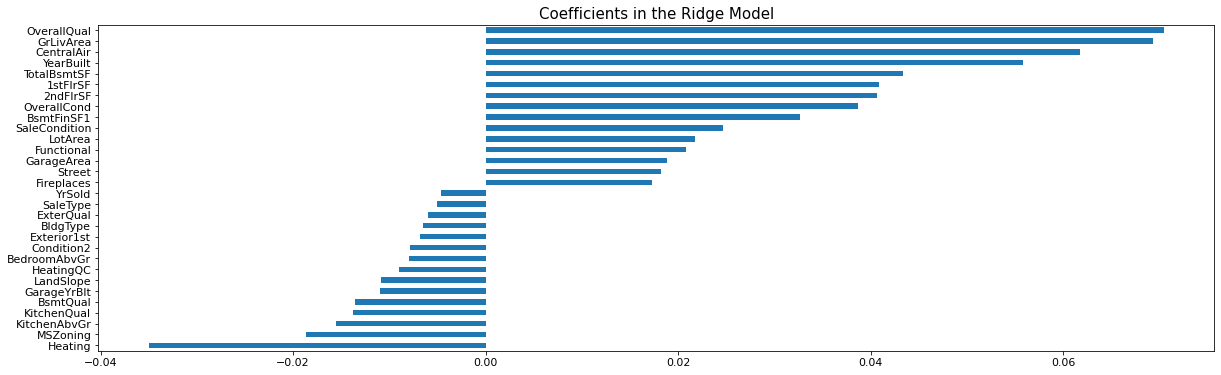

In [38]:
# Plotting Important coefficient of Ridge Regression 
coefs = pd.Series(ridge_clf.coef_, index = X_train.columns)

print('Ridge picked {} features and dropped {} features'.format(sum(coefs !=0), sum(coefs==0)))
imp_coefs = pd.concat([coefs.sort_values().head(15),
                     coefs.sort_values().tail(15)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model", size=15)
plt.show()

In [39]:
predictions = ridge_clf.predict(test_df)

kaggle_submission_output = pd.DataFrame ({'Id': test_df_copy['Id'], 'SalePrice':predictions })
kaggle_submission_output.to_csv ('House_Price_Prediction_submission.csv', index=False)

print('Output submitted Successfully')

Output submitted Successfully
